In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from utils.utils import *

# Для воспроизводимости
np.random.seed(42)
torch.manual_seed(42)

In [35]:
df = pd.read_csv(get_project_root() / 'data/Belyy2017_GHG_zscore.csv')

# Предполагая, что в данных есть столбец 'Date' и целевой столбец 'Value'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Нормализация данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['up_CO'].values.reshape(-1, 1))

# Разделение данных
train_size = int(len(df['up_CO'].values.reshape(-1, 1)) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Создание последовательностей
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

seq_length = 50
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True)
        self.linear1 = nn.Linear(hidden_layer_size, 100)
        self.linear2 = nn.Linear(100, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm1(input_seq)
        lstm_out, self.hidden_cell = self.lstm2(lstm_out)
        linear1_out = self.linear1(lstm_out[:, -1])
        predictions = self.linear2(linear1_out)
        return predictions

input_size = 1  # Одномерный временной ряд
hidden_layer_size = 100
output_size = 1

model = LSTM(input_size, hidden_layer_size, output_size)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
epochs = 100

for epoch in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1} loss: {single_loss.item()}')

Epoch 1 loss: 0.00036551544326357543
Epoch 2 loss: 0.0005335303721949458
Epoch 3 loss: 0.0003739201929420233
Epoch 4 loss: 0.001060101785697043
Epoch 5 loss: 0.00030332570895552635
Epoch 6 loss: 0.00010817969450727105
Epoch 7 loss: 0.00018059779540635645
Epoch 8 loss: 0.0008975720847956836
Epoch 9 loss: 0.0006616165628656745
Epoch 10 loss: 0.00044243349111638963
Epoch 11 loss: 0.00010977348574670032
Epoch 12 loss: 0.001272414461709559
Epoch 13 loss: 0.00043945651850663126
Epoch 14 loss: 0.0009181215427815914
Epoch 15 loss: 0.007787360344082117
Epoch 16 loss: 6.293800834100693e-05
Epoch 17 loss: 0.002792739775031805
Epoch 18 loss: 0.0007311731460504234
Epoch 19 loss: 8.798181806923822e-05
Epoch 20 loss: 0.0006816095556132495
Epoch 21 loss: 0.0040482403710484505
Epoch 22 loss: 0.00015676100156269968
Epoch 23 loss: 0.0006152733112685382
Epoch 24 loss: 0.00046638809726573527
Epoch 25 loss: 0.0003837441618088633
Epoch 26 loss: 8.119588164845482e-05
Epoch 27 loss: 0.0004077415505889803
Epoch

MAPE: 44.675701104923
MAE: 0.23526587453694536


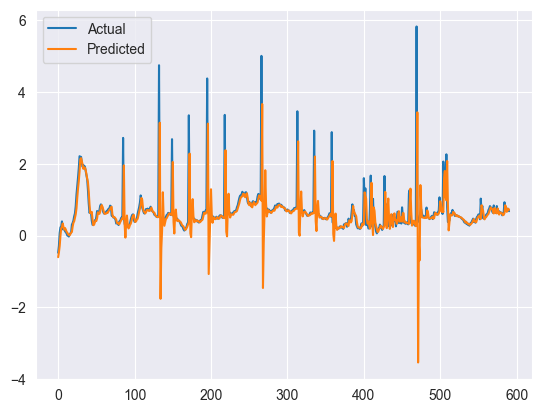

In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

model.eval()

test_predictions = []
test_labels = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = model(seq)
        test_predictions.extend(y_pred.numpy())
        test_labels.extend(labels.numpy())

test_predictions = scaler.inverse_transform(test_predictions)
test_labels = scaler.inverse_transform(test_labels)

mape = mean_absolute_percentage_error(test_labels, test_predictions)
mae = mean_absolute_error(test_labels, test_predictions)

print(f'MAPE: {mape}')
print(f'MAE: {mae}')

# Построение графиков
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.legend()
plt.show()